<a href="https://colab.research.google.com/github/WanQi-K/DataSciencePortfolio/blob/main/29_How_I_Cracked_the_Code_to_Malaysia%E2%80%99s_Cheapest_Domestic_Flights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
# Import from GoogleDrive
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1-222xi4VDhjKdOdh6wUcAiVPd4kMJvF1'}) # Replace YOUR_FILE_ID with the actual file ID
downloaded.GetContentFile('29.kul_pen_flight_data_2025-03-18.csv') # Replace your_file.csv with the desired file name

In [ ]:
import pandas as pd
data = pd.read_csv('29.kul_pen_flight_data_2025-03-18.csv') # Replace your_file.csv with the downloaded file name

### Data Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load and clean
data = data.drop_duplicates(subset=['Departure Time', 'Arrival Time', 'Airline', 'Departure Date', 'Price'])
data['Departure Date'] = pd.to_datetime(data['Departure Date'], format='%d/%m/%Y')
data['Scrape Date'] = pd.to_datetime(data['Scrape Date'], format='%d/%m/%Y')
data['Days Until Departure'] = (data['Departure Date'] - data['Scrape Date']).dt.days
data['Price'] = data['Price'].replace('[\$,]', '', regex=True).astype(float)
data['Time of Day'] = data['Departure Time'].apply(
    lambda x: 'Morning' if pd.to_datetime(x, format='%I:%M %p').time() < pd.to_datetime('12:00 PM', format='%I:%M %p').time() else
              'Afternoon' if pd.to_datetime(x, format='%I:%M %p').time() < pd.to_datetime('6:00 PM', format='%I:%M %p').time() else 'Night'
)
data['Day of Week'] = data['Departure Date'].dt.dayofweek
data['Weekend (Fri-Sun)'] = data['Day of Week'].isin([4, 5, 6]).astype(int)


<ipython-input-5-25e655e713ca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Departure Date'] = pd.to_datetime(data['Departure Date'], format='%d/%m/%Y')
<ipython-input-5-25e655e713ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Scrape Date'] = pd.to_datetime(data['Scrape Date'], format='%d/%m/%Y')
<ipython-input-5-25e655e713ca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [ ]:
data

,Departure Time,Arrival Time,Airline,Flight Duration,Stops,Price,CO2 Emissions,Emissions Variation,Departure Date,Scrape Date,Departure Airport,Arrival Airport,Days Until Departure,Time of Day,Day of Week,Weekend (Fri-Sun)
0,4:00 PM,5:00 PM,Batik Air,1 hr,Nonstop,45.0,56 kg CO2e,+10% emissions,2025-03-19,2025-03-18,KUL,PEN,1,Afternoon,2,0
1,3:05 PM,4:05 PM,AirAsia,1 hr,Nonstop,45.0,51 kg CO2e,Avg emissions,2025-03-19,2025-03-18,KUL,PEN,1,Afternoon,2,0
2,1:50 PM,2:50 PM,Malaysia Airlines,1 hr,Nonstop,69.0,51 kg CO2e,Avg emissions,2025-03-19,2025-03-18,KUL,PEN,1,Afternoon,2,0
3,10:00 PM,11:00 PM,Batik Air,1 hr,Nonstop,45.0,56 kg CO2e,+10% emissions,2025-03-19,2025-03-18,KUL,PEN,1,Night,2,0
4,11:20 PM,12:20 AM+1,Malaysia Airlines,1 hr,Nonstop,53.0,51 kg CO2e,Avg emissions,2025-03-19,2025-03-18,KUL,PEN,1,Night,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,8:05 AM,9:05 AM,Malaysia Airlines,1 hr,Nonstop,20.0,56 kg CO2e,+10% emissions,2025-06-18,2025-03-18,KUL,PEN,92,Morning,2,0
3579,11:45 AM,12:45 PM,Malaysia Airlines,1 hr,Nonstop,30.0,51 kg CO2e,Avg emissions,2025-06-18,2025-03-18,KUL,PEN,92,Morning,2,0
3580,2:05 PM,3:05 PM,Malaysia Airlines,1 hr,Nonstop,30.0,51 kg CO2e,Avg emissions,2025-06-18,2025-03-18,KUL,PEN,92,Afternoon,2,0
3581,11:35 PM,12:35 AM+1,Malaysia Airlines,1 hr,Nonstop,30.0,51 kg CO2e,Avg emissions,2025-06-18,2025-03-18,KUL,PEN,92,Night,2,0


### EDA

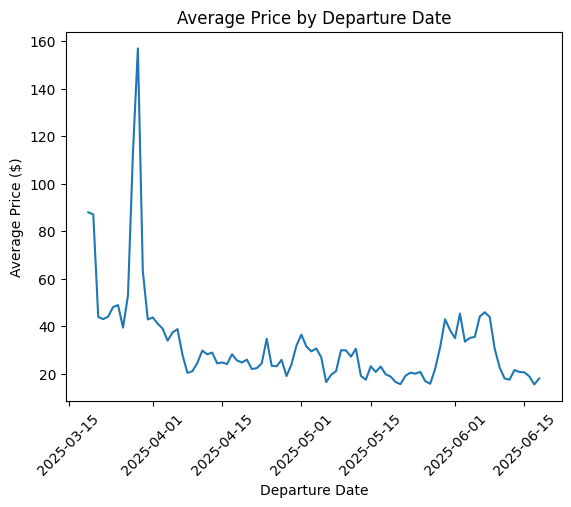

Price trend: High near-term ($80-$160), drops to $20-$30 long-term (60+ days).


In [ ]:
# Trend of Flight Ticket Price
price_trend = data.groupby('Departure Date')['Price'].mean()
plt.plot(price_trend.index, price_trend.values)
plt.title('Average Price by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.show()
print("Price trend: High near-term ($80-$160), drops to $20-$30 long-term (60+ days).")

# Spike near the end of Mar, believe this is due to festive season (Hari Raya)

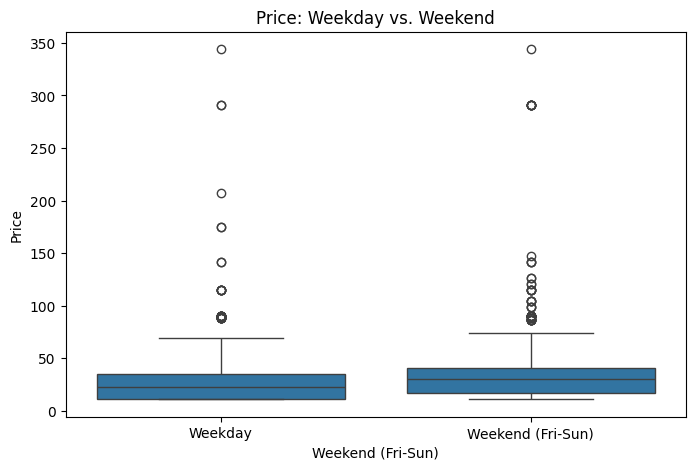

Weekend vs. Weekday T-test: p-value = 0.0000

Fri-Sun Weekend:
Weekday avg: $28.12, Weekend avg: $36.31
Weekday flights: 1024, Weekend flights: 777


In [ ]:
# 2. Weekend vs. Weekday - Boxplot + T-test
plt.figure(figsize=(8, 5))
sns.boxplot(x='Weekend (Fri-Sun)', y='Price', data=data)
plt.xticks([0, 1], ['Weekday', 'Weekend (Fri-Sun)'])
plt.title('Price: Weekday vs. Weekend')
plt.show()
weekday_prices = data[data['Weekend (Fri-Sun)'] == 0]['Price']
weekend_prices = data[data['Weekend (Fri-Sun)'] == 1]['Price']
t_stat, p_val = ttest_ind(weekday_prices, weekend_prices)
print(f"Weekend vs. Weekday T-test: p-value = {p_val:.4f}")

fri_sun_avg = data.groupby('Weekend (Fri-Sun)')['Price'].mean()
fri_sun_count = data['Weekend (Fri-Sun)'].value_counts()

print("\nFri-Sun Weekend:")
print(f"Weekday avg: ${fri_sun_avg[0]:.2f}, Weekend avg: ${fri_sun_avg[1]:.2f}")
print(f"Weekday flights: {fri_sun_count[0]}, Weekend flights: {fri_sun_count[1]}")

# Null hypothesis : No significant difference in weekends vs weekdays price
# Since p-value is very small, we have to reject the Null hypothesis
# Conclusion, statistically there is a significant dofferent in average flight prices between weekdays and weekends

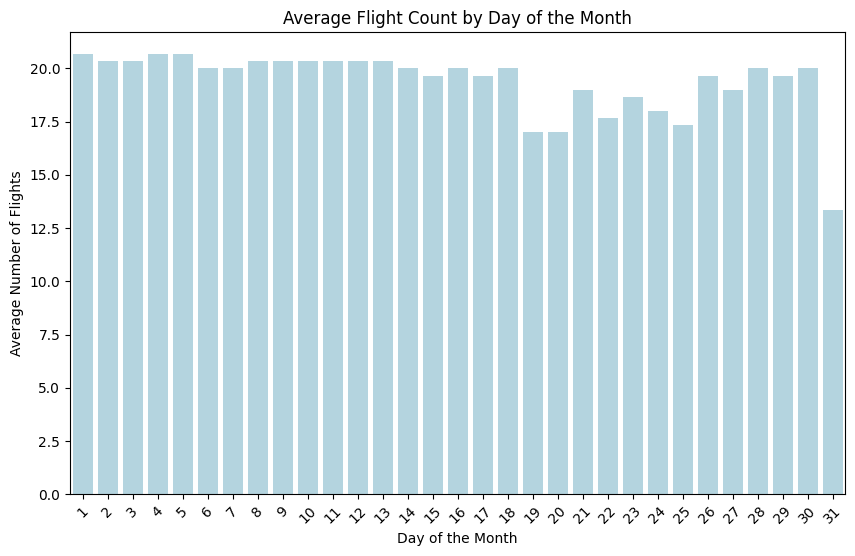

Flight counts across the month—any end-of-month spike?

Average Flight Count (Days 25-31): 18.4
Average Flight Count (Days 10-20): 19.5
Higher at month-end? Could mean more trips.


In [ ]:
# Does flight frequency fluactuate?

#Extract day of the month
data['Day of Month'] = data['Departure Date'].dt.day

#Calculate average flight count per day of month
avg_freq_by_day = data.groupby('Day of Month')['Departure Date'].count() / (data['Departure Date'].dt.daysinmonth.nunique()+1)
avg_freq_by_day = avg_freq_by_day.rename('Average Daily Flight Count')

#Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_freq_by_day.index, y=avg_freq_by_day.values, color='lightblue')
plt.title('Average Flight Count by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Average Number of Flights')
plt.xticks(rotation=45)
plt.show()
print("Flight counts across the month—any end-of-month spike?")

# End-of-Month vs. Mid-Month (using average flight counts)
end_of_month = avg_freq_by_day[avg_freq_by_day.index >= 25].mean()
mid_month = avg_freq_by_day[(avg_freq_by_day.index >= 10) & (avg_freq_by_day.index <= 20)].mean()
print(f"\nAverage Flight Count (Days 25-31): {end_of_month:.1f}")
print(f"Average Flight Count (Days 10-20): {mid_month:.1f}")
print("Higher at month-end? Could mean more trips.")

# Seems like flight count is consistent, which means supply of capacity is stable

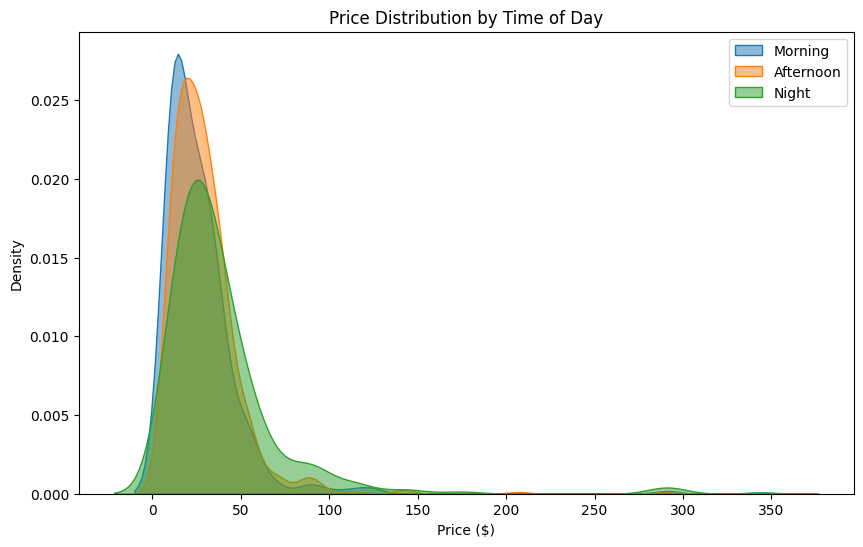

In [ ]:
# 3. Time of Day - KDE Plot
plt.figure(figsize=(10, 6))
for tod in ['Morning', 'Afternoon', 'Night']:
    sns.kdeplot(data=data[data['Time of Day'] == tod], x='Price', label=tod, fill=True, alpha=0.5)
plt.title('Price Distribution by Time of Day')
plt.xlabel('Price ($)')
plt.legend()
plt.show()

# Surprisingly enough, night time seems to the cheapest? Why? Could it be because this is short trip
# And people will prefer to leave in the morning?

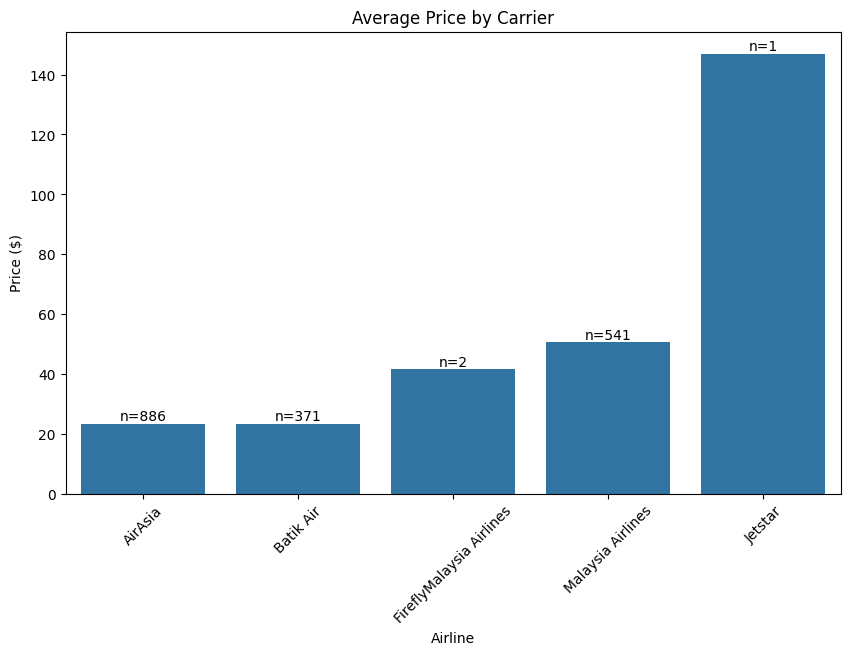

In [ ]:
# 4. Economic Carrier - Bar Plot
carrier_stats = data.groupby('Airline')['Price'].agg(['mean', 'count']).sort_values('mean')
plt.figure(figsize=(10, 6))
sns.barplot(x=carrier_stats.index, y='mean', data=carrier_stats)
for i, v in enumerate(carrier_stats['count']):
    plt.text(i, carrier_stats['mean'].iloc[i] + 1, f'n={v}', ha='center')
plt.title('Average Price by Carrier')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.show()

#Found 2 outliers, Jetstar and FirelyMalaysia Airlines

In [ ]:
airline_group=data.groupby('Airline').size()
airline_group

,0
Airline,
AirAsia,886
Batik Air,371
FireflyMalaysia Airlines,2
Jetstar,1
Malaysia Airlines,541


In [ ]:
# Drop outliers
data=data.drop(data[data['Airline']=='Jetstar'].index)
data=data.drop(data[data['Airline']=='FireflyMalaysia Airlines'].index)

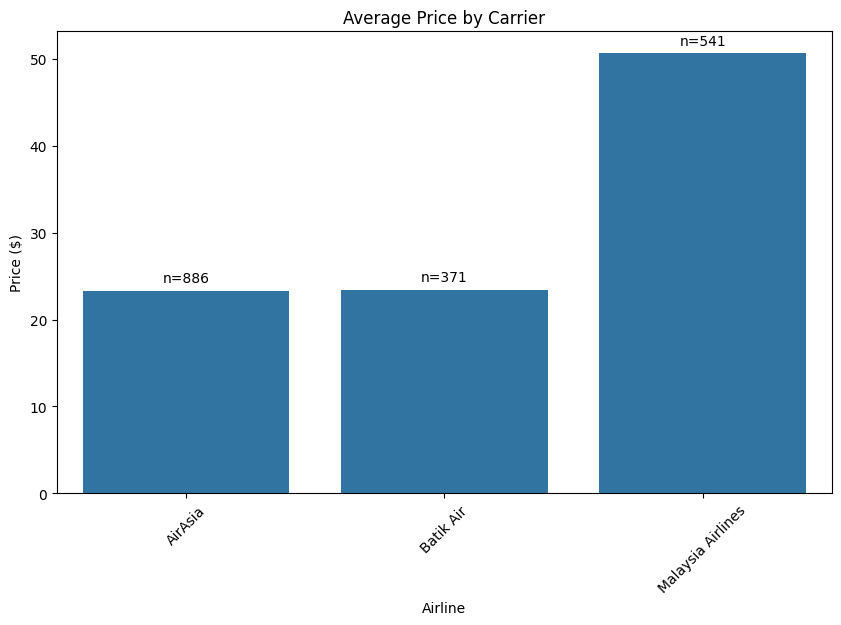

In [ ]:
# 4. Economic Carrier - Bar Plot
carrier_stats = data.groupby('Airline')['Price'].agg(['mean', 'count']).sort_values('mean')
plt.figure(figsize=(10, 6))
sns.barplot(x=carrier_stats.index, y='mean', data=carrier_stats)
for i, v in enumerate(carrier_stats['count']):
    plt.text(i, carrier_stats['mean'].iloc[i] + 1, f'n={v}', ha='center')
plt.title('Average Price by Carrier')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.show()

#Air Asia & Batik Air is the budget friendly carriers

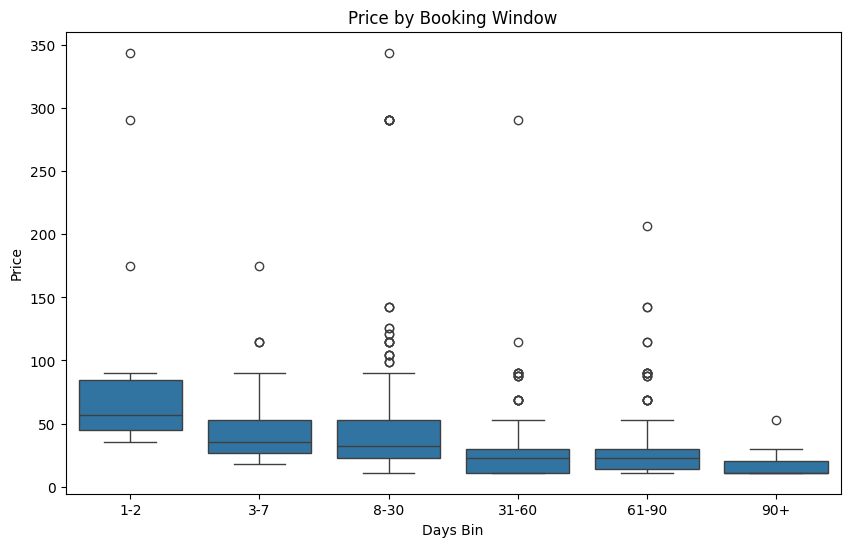

In [ ]:
# 5. Optimal Time - Boxplot
data['Days Bin'] = pd.cut(data['Days Until Departure'], bins=[0, 2, 7, 30, 60, 90, float('inf')],
                          labels=['1-2', '3-7', '8-30', '31-60', '61-90', '90+'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='Days Bin', y='Price', data=data)
plt.title('Price by Booking Window')
plt.show()

# More outliers flight ticket price for those who purchase <30 days before departure
# So need to becareful when making purchases

In [ ]:
# Optimal Time to Purchase
bins = [0, 2, 7, 30, 60, 90, float('inf')]
labels = ['1-2 days', '3-7 days', '8-30 days', '31-60 days', '61-90 days', '90+ days']
data['Days Bin'] = pd.cut(data['Days Until Departure'], bins=bins, labels=labels, right=False)
days_avg = data.groupby('Days Bin')['Price'].mean()
print("\nAverage Price by Days Until Departure:")
print(days_avg)

# This is a more detailed breakdown, where last minute purchase is the most expensive


Average Price by Days Until Departure:
Days Bin
1-2 days      87.900000
3-7 days      51.594595
8-30 days     43.050773
31-60 days    25.414309
61-90 days    27.111667
90+ days      17.400000
Name: Price, dtype: float64


<ipython-input-16-6de0fe1aeafb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  days_avg = data.groupby('Days Bin')['Price'].mean()



Cheapest Day: Tuesday - Avg Fare: $24.08, Flights: 254
Lowest Flight Count Day: Thursday - Flights: 246, Avg Fare: $32.90


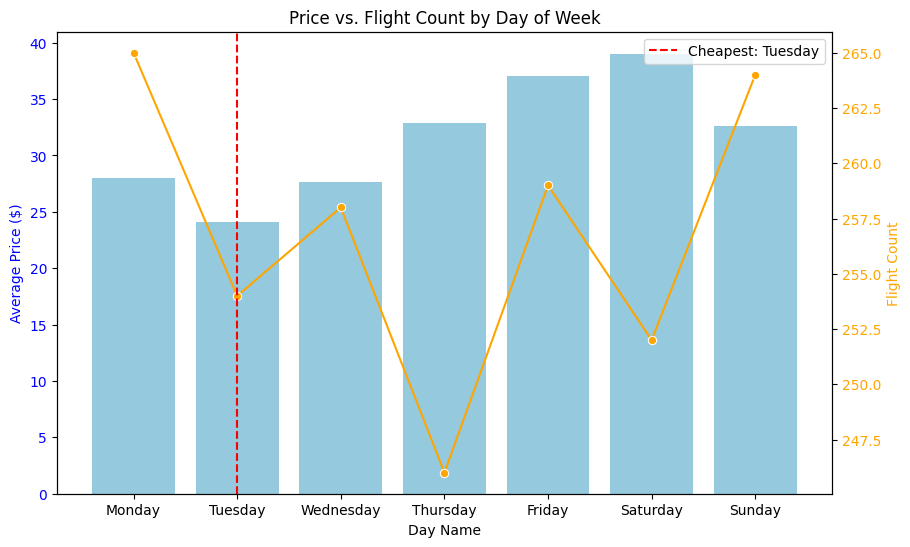

In [ ]:
# Which is the cheapest day to travel?
# Calculate average price and flight count by day of week
day_stats = data.groupby('Day of Week').agg(
    Avg_Price=('Price', 'mean'),
    Flight_Count=('Price', 'size')
).reset_index()
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
day_stats['Day Name'] = day_stats['Day of Week'].map(day_names)

# Find cheapest day and lowest flight count day
cheapest_day = day_stats.loc[day_stats['Avg_Price'].idxmin()]
lowest_count_day = day_stats.loc[day_stats['Flight_Count'].idxmin()]
print(f"\nCheapest Day: {cheapest_day['Day Name']} - Avg Fare: ${cheapest_day['Avg_Price']:.2f}, Flights: {cheapest_day['Flight_Count']}")
print(f"Lowest Flight Count Day: {lowest_count_day['Day Name']} - Flights: {lowest_count_day['Flight_Count']}, Avg Fare: ${lowest_count_day['Avg_Price']:.2f}")

# Plot prices and flight counts side by side
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x='Day Name', y='Avg_Price', data=day_stats, ax=ax1, color='skyblue', order=day_names.values())
ax1.set_ylabel('Average Price ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Price vs. Flight Count by Day of Week')

ax2 = ax1.twinx()
sns.lineplot(x='Day Name', y='Flight_Count', data=day_stats, ax=ax2, color='orange', marker='o', sort=False)
ax2.set_ylabel('Flight Count', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.axvline(x=cheapest_day['Day of Week'], color='red', linestyle='--', label=f'Cheapest: {cheapest_day["Day Name"]}')
plt.legend()
plt.show()

### Machine Learning

In [ ]:
data.head()

,Departure Time,Arrival Time,Airline,Flight Duration,Stops,Price,CO2 Emissions,Emissions Variation,Departure Date,Scrape Date,Departure Airport,Arrival Airport,Days Until Departure,Time of Day,Day of Week,Weekend (Fri-Sun),Day of Month,Days Bin
0,4:00 PM,5:00 PM,Batik Air,1 hr,Nonstop,45.0,56 kg CO2e,+10% emissions,2025-03-19,2025-03-18,KUL,PEN,1,Afternoon,2,0,19,1-2 days
1,3:05 PM,4:05 PM,AirAsia,1 hr,Nonstop,45.0,51 kg CO2e,Avg emissions,2025-03-19,2025-03-18,KUL,PEN,1,Afternoon,2,0,19,1-2 days
2,1:50 PM,2:50 PM,Malaysia Airlines,1 hr,Nonstop,69.0,51 kg CO2e,Avg emissions,2025-03-19,2025-03-18,KUL,PEN,1,Afternoon,2,0,19,1-2 days
3,10:00 PM,11:00 PM,Batik Air,1 hr,Nonstop,45.0,56 kg CO2e,+10% emissions,2025-03-19,2025-03-18,KUL,PEN,1,Night,2,0,19,1-2 days
4,11:20 PM,12:20 AM+1,Malaysia Airlines,1 hr,Nonstop,53.0,51 kg CO2e,Avg emissions,2025-03-19,2025-03-18,KUL,PEN,1,Night,2,0,19,1-2 days


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd
import shap

# Features
data['Hour'] = pd.to_datetime(data['Departure Time'], format='%I:%M %p').dt.hour
freq_by_day = data.groupby('Day of Month').size().rename('Daily Flight Count')
data = data.merge(freq_by_day, on='Day of Month')

# Features (full set for training)
features = ['Airline', 'Time of Day', 'Day of Week', 'Days Until Departure', 'Hour', 'Daily Flight Count']
X = pd.get_dummies(data[features], drop_first=True)
y = data['Price']


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}
xgb_model = xgb.XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")

Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


MAE: $6.71, % within $5: 65.83%


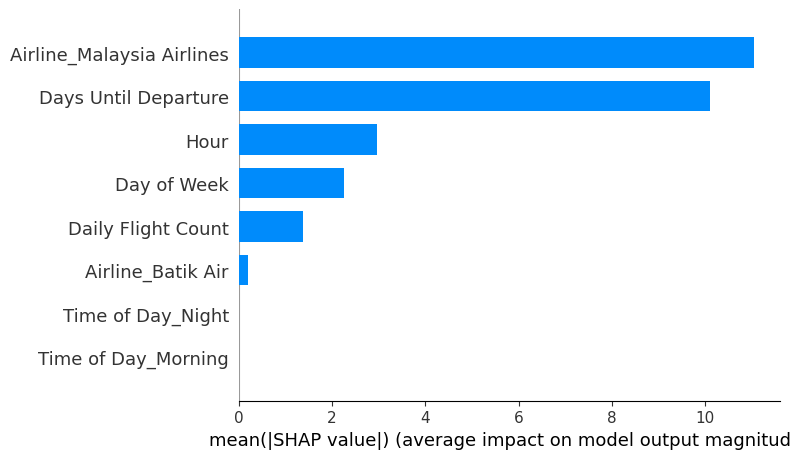

SHAP shows what drives price—e.g., Days Until Departure dominates.


In [ ]:
# Predict and Evaluate
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
within_5 = np.mean(np.abs(y_test - y_pred) <= 5) * 100
print(f"MAE: ${mae:.2f}, % within $5: {within_5:.2f}%")

# SHAP Explainability
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
print("SHAP shows what drives price—e.g., Days Until Departure dominates.")

# Simplified Prediction Function
def predict_price(airline, time_of_day, day_of_week, days_until_departure, model, feature_cols):
    # Default values for Hour and Daily Flight Count
    time_to_hour = {'Morning': 9, 'Afternoon': 15, 'Night': 20}  # Typical hours
    default_flight_count = data['Daily Flight Count'].median()  # Median flight count

    # Create input dataframe
    user_input = pd.DataFrame({
        'Airline': [airline],
        'Time of Day': [time_of_day],
        'Day of Week': [day_of_week],  # Friday = 4
        'Days Until Departure': [days_until_departure],
        'Hour': [time_to_hour[time_of_day]],
        'Daily Flight Count': [default_flight_count]
    })

    # Convert to dummy variables and align with training columns
    user_input = pd.get_dummies(user_input).reindex(columns=feature_cols, fill_value=0)

    # Predict
    pred = model.predict(user_input)[0]
    return pred

In [ ]:
# Your Scenario: Friday, Evening, AirAsia, 90 days out (0-Monday, 6-Sunday)
price = predict_price('AirAsia', 'Afternoon', 4, 90, best_model, X.columns)
print(f"Expected Price (AirAsia, Friday, Afternoon, 90 days): ${price:.2f}")

Expected Price (AirAsia, Friday, Afternoon, 90 days): $15.56


For Savers:
Choose Night (after 6 PM), Weekends (Fri-Sun), book 60+ days out.

# Compare against Predicted Price vs Actual Price

Training on 1438 flights, testing on 360
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
MAE: $6.71
% within $5: 65.83%


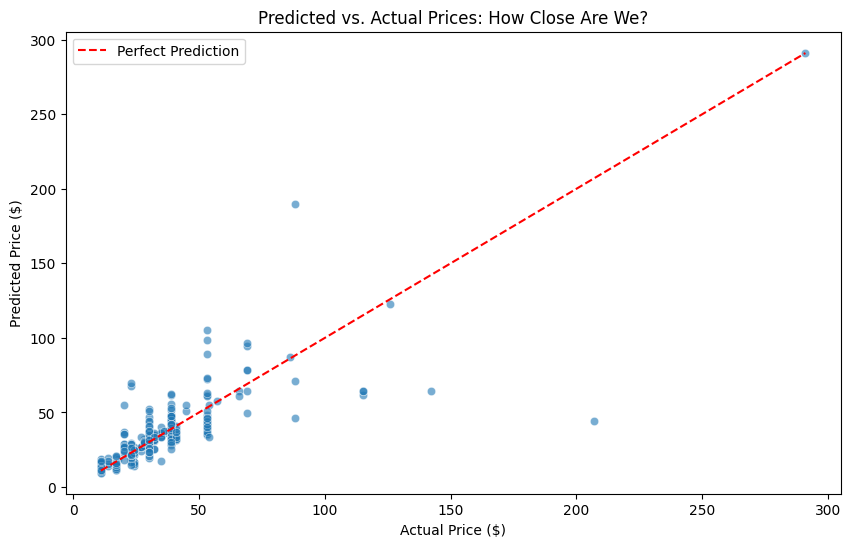


Sample Comparisons (First 5):
      Actual  Predicted  Difference
1278    11.0  13.086928   -2.086928
220     36.0  36.293133   -0.293133
1519    30.0  43.602364  -13.602364
438     17.0  19.370516   -2.370516
1271    39.0  35.931808    3.068192

Biggest Underestimate: $-101.82
Biggest Overestimate: $162.43


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Features and target
features = ['Airline', 'Time of Day', 'Day of Week', 'Days Until Departure', 'Hour', 'Daily Flight Count']
X = pd.get_dummies(data[features], drop_first=True)
y = data['Price']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training on {len(X_train)} flights, testing on {len(X_test)}")

# Train the XGBoost model (your tuned version)
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 5, 7]}
xgb_model = xgb.XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")

# Predict on test set
y_pred = best_model.predict(X_test)

# Combine actual and predicted into a dataframe
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison['Difference'] = comparison['Actual'] - comparison['Predicted']

# Metrics
mae = mean_absolute_error(y_test, y_pred)
within_5 = (comparison['Difference'].abs() <= 5).mean() * 100
print(f"MAE: ${mae:.2f}")
print(f"% within $5: {within_5:.2f}%")

# Plot predicted vs. actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=comparison, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Predicted vs. Actual Prices: How Close Are We?')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.legend()
plt.show()

# Summary stats
print("\nSample Comparisons (First 5):")
print(comparison.head())
print(f"\nBiggest Underestimate: ${comparison['Difference'].min():.2f}")
print(f"Biggest Overestimate: ${comparison['Difference'].max():.2f}")